In [1]:
import jax
import jax.numpy as jnp
from jax.scipy import stats
from jax.scipy.special import logsumexp
import scipy
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# problem definition
- assume that the number of dimensions is fixed
- we want to find a threshold for the number of training points $n_t$ such that:
    - a model trained on $n < n_t$ points will have accuracy < 90%
    - a model trained on $n \geq n_t$ points will have accuracy ≥ 90%
- let's assume (as a simplification) that the distribution of the measured accuracy for each $n$ is $N(\mu_n, \sigma_n^2)$
    - let's assume a conjugate non-informative $\text{Normal-gamma}[0, 0, 0, 0]$ prior for $\mu_n$ and $\sigma_n$
    - after conditioning on the measured model accuracy, we get a new posterior over $\mu_n$ and $\sigma_n$
    - the marginal posterior for $\mu_n$ is a non-central t-distribution
    - once we have the posteriors over $\mu_n$, we can define our threshold as a value $n_t$ such that
        - $(\forall n, n<n_t: \mu_n < 0.9) \land (\forall n, n \geq n_t: \mu_n \geq 0.9)$
    - if we set a uniform prior over $n_t$, the posterior is proportional to the likelihood (which we can evaluate using the above expression)
    - by computing the posterior expectation of $n_t$ we can finally get a point estimate for $n_t$
- background reading: [sequential analysis](https://en.wikipedia.org/wiki/Sequential_analysis)

# example
- for demo purposes, let's set:
    - $\text{accuracy}_n \sim N(\mu_n, \sigma_n^2)$
    - $\mu_n = \frac{n}{100}$
    - $\sigma=0.1$

In [2]:
# define experiment
n_observations = 200 # number of times each distribution is samples
n_values = 100 # in each experiment, we'll test n=1..<n_values
n = 1 + jnp.arange(n_values)
mu = jnp.linspace(0, 1, n_values) # true values of mu_n
sigma = 0.1 # true value of sigma
key = jax.random.PRNGKey(0)
accuracy = (mu[None] + sigma*jax.random.normal(key, shape=[n_observations, n_values])).clip(0, 1) # outcomes of each experiment
thr = 0.9 # the target threshold for model accuracy
thr_idx = jnp.argmax(mu > thr) # index of first n that attains the threshold
thr_n = n[thr_idx]

# naive early stopping

In [3]:
# stop each experiment once accuracy crosses threshold
thr_idx_hat = jnp.argmax(accuracy > thr, axis=1)

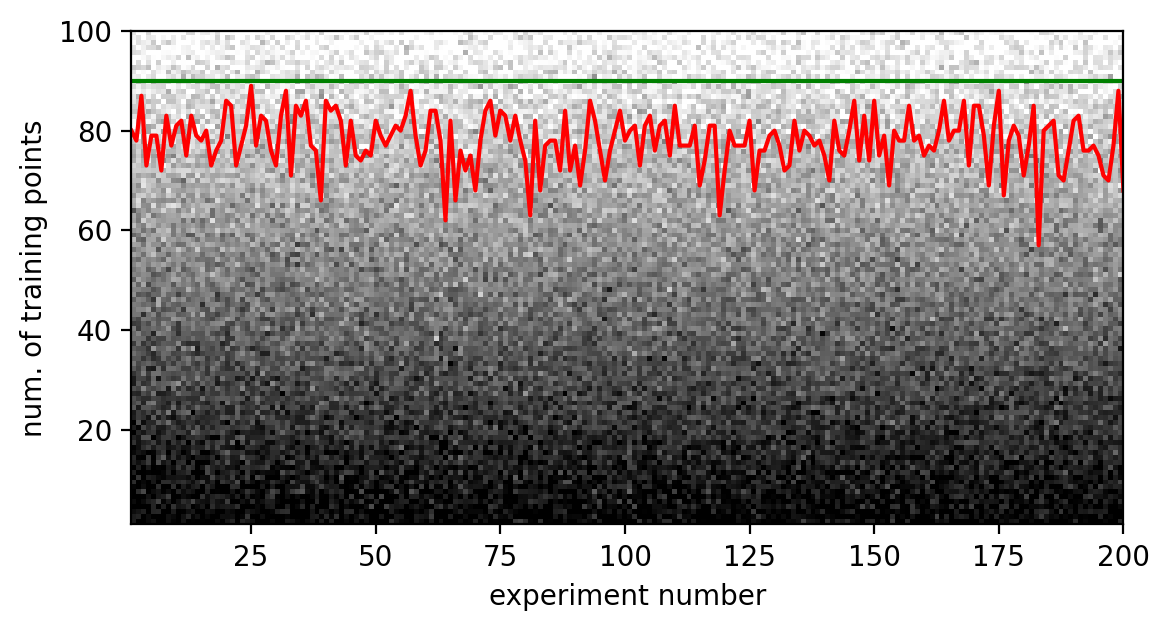

In [4]:
# our estimator of the threshold (red line) is biased (true value is green line)
fig, ax = plt.subplots()
ax.imshow(accuracy.T, cmap='gray', origin='lower', extent=[1, n_observations, 1, n_values])
ax.plot(1+jnp.arange(n_observations), thr_idx_hat, color='red')
ax.axhline(thr_idx, color='green')
ax.set_xlabel('experiment number')
ax.set_ylabel('num. of training points')
plt.show()

# a better approach

In [5]:
def condition_normal_gamma(x, prior_n_observations=0.01, prior_mean=0.5, prior_std=0.5):
    """
    x: observed data, shape=[nun. of observations for a each distribution, num. of different distributions to fit]
    """
    
    # translate summary of prior observations into prior paramaters
    prior_mu = prior_mean
    prior_nu = prior_n_observations
    prior_a = prior_n_observations / 2
    prior_b = prior_n_observations * prior_std**2 / 2
    
    # compute posterior parameters
    n = len(x) # nun. of observations for each distribution
    x_mean = x.mean(0, keepdims=True)
    post_mu = (prior_nu*prior_mu + n*x_mean) / (prior_nu + n)
    post_nu = prior_nu + n
    post_a = prior_a + n/2
    post_b = prior_b + 1/2 * ((x - x_mean)**2).sum(0, keepdims=True) + (n*prior_nu)/(prior_nu + n) * ((x_mean - prior_mu)**2)/2
    
    return post_mu.squeeze(0), post_nu, post_a, post_b.squeeze(0)

def mu_posterior_cdf(q, x):
    """
    - q: mu posterior quantile (scalar)
    - x: observed data, shape=[nun. of observations for a each distribution, num. of different distributions to fit]
    """
    # assume an uninformative normal-gamma prior for (mu, sigma)
    # assume normal likelihood
    # after conditioning on the observed data, we get a normal-gamma
    # distribution with the following parameters:
    # https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution
    post_mu, post_nu, post_a, post_b = condition_normal_gamma(x)
    
    # the marginal distribution for mu a noncentral t-distribution
    # with the following parameters
    # https://en.wikipedia.org/wiki/Normal-gamma_distribution#Marginal_distributions
    marg_nu = 2*post_a
    marg_mu = post_mu
    marg_sigma = jnp.sqrt(post_b / (post_nu * post_a))
    
    # returns the log-CDF for the marginal distribution of mu
    return scipy.stats.t.cdf(q, df=marg_nu, loc=marg_mu, scale=marg_sigma)

def get_thr_likelihood(p_mu_below_thr, idx):
    """
    p_mu_below_thr is a vector of probabilities that mu < threshold
    (each element in the vector corresponds to a single n).
    This function computes the probability that:
    - (mu < threshold) for all (n < idx) and
    - (mu ≥ threshold) for all (n ≥ idx)
    p_mu_below_thr.shape = [num. of different distributions]
    """
    n_values = len(p_mu_below_thr)
    value_expected_below_thr = (jnp.arange(n_values) < idx)
    log_probs = scipy.stats.bernoulli.logpmf(value_expected_below_thr, p_mu_below_thr)
    return jnp.exp(log_probs.sum())

def get_thr_posterior(accuracy, thr=0.9):
    """
    Computes posterior distribution for the threshold index 'idx'.
    The 'idx' value is defined as:
    - (mu < threshold) for all (n < idx) and
    - (mu ≥ threshold) for all (n ≥ idx)
    accuracy.shape = [nun. of observations for a each distribution, num. of different distributions to fit]
    """
    n_observations, n_values = accuracy.shape
    p_mu_below_thr = mu_posterior_cdf(thr, accuracy)
    likelihood_thr = jnp.array([get_thr_likelihood(p_mu_below_thr, idx) for idx in range(n_values)])
    posterior_thr = likelihood_thr / likelihood_thr.sum()
    return p_mu_below_thr, posterior_thr

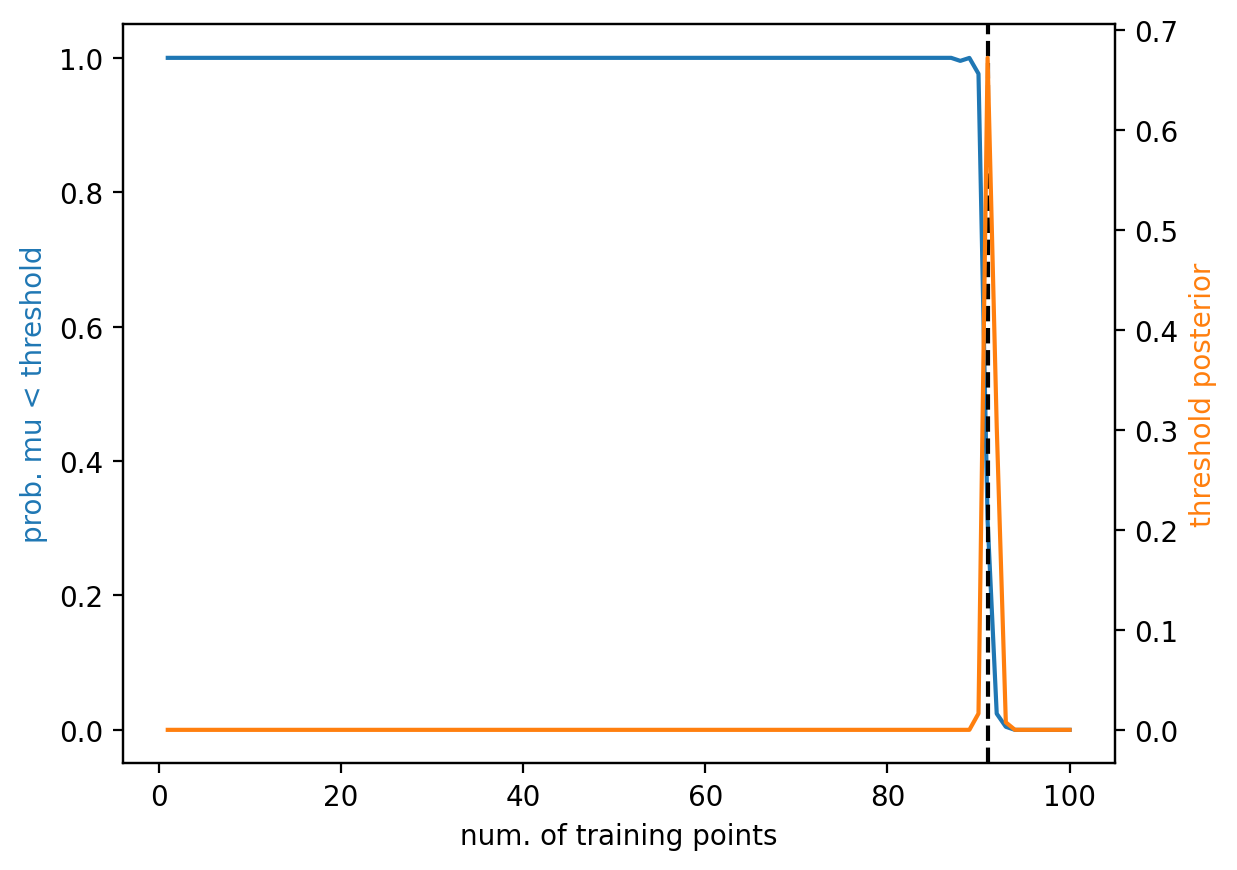

In [6]:
p_mu_below_thr, posterior_thr = get_thr_posterior(accuracy, thr)
fig, ax1 = plt.subplots()
ax1.plot(n, p_mu_below_thr, color='C0')
ax1.axvline(thr_n, color='black', ls='--')
ax2 = ax1.twinx()
ax2.plot(n, posterior_thr, color='C1')
ax1.set_xlabel('num. of training points')
ax1.set_ylabel('prob. mu < threshold', color='C0')
ax2.set_ylabel('threshold posterior', color='C1')
plt.show()

In [7]:
# get point estimate for threshold n
post_mean = (n*posterior_thr).sum()
post_std = jnp.sqrt(((n - post_mean)**2 * posterior_thr).sum())
L = n[jnp.argmax(jnp.cumsum(posterior_thr) > 0.05)]
U = n[jnp.argmax(jnp.cumsum(posterior_thr) > 0.95)]
print(f'threshold = {post_mean:.3f} ± {post_std:.3f}')
print(f'95% CI: {float(L)} - {float(U)}')

threshold = 91.303 ± 0.509
95% CI: 91.0 - 92.0


In [8]:
# x_plot = jnp.linspace(15, 25, 1000)
# pdf = stats.t.pdf(x_plot, df=marg_nu, loc=marg_mu, scale=marg_sigma)
# plt.plot(x_plot, pdf)